# Exercises Sheet 1 - Simulations

## 1. Calculate $\pi$ using Monte Carlo

In [57]:
# x^2 + y^2 <= r^2
function calculate_pi(N = 1000)
    S = 0
    x, y = rand(N), rand(N)
    c    = zeros(N)
    for i in 1:N
        if x[i]^2+y[i]^2 <= 1
            S+=1
            c[i] = 1
        end
    end
    π = 4*S/N
    return π,x,y,c
end

calculate_pi (generic function with 2 methods)

In [58]:
N = [100,1_000,10_000,100_000]
v,x,y,c = calculate_pi(10_000)

(3.1372, [0.184509, 0.410335, 0.184362, 0.208964, 0.276852, 0.132321, 0.532255, 0.794572, 0.12439, 0.156422  …  0.236886, 0.466622, 0.980936, 0.721202, 0.857775, 0.145508, 0.643833, 0.743415, 0.902879, 0.834706], [0.991154, 0.45775, 0.895317, 0.368089, 0.436428, 0.138815, 0.350879, 0.111998, 0.318554, 0.503979  …  0.507532, 0.91006, 0.61587, 0.269054, 0.865263, 0.277387, 0.84639, 0.584342, 0.0834817, 0.979213], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0])

In [59]:
using Plots; pyplot()

Plots.PyPlotBackend()

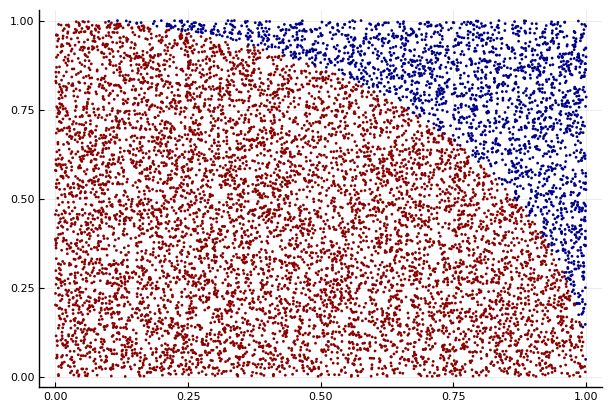

In [67]:
p = scatter(x,y,zcolor=c,markersize=2,markerstrokewidth = 0,c=:bluesreds,fmt =:png,legend=false)
savefig(p,"./images/MonteCarlo_Pi.png")

## 2. *Box-Muller*

In [5]:
function box_muller(N=100)
    R = (-2*log.(rand(N))).^(1/2)
    v = 2*π*rand(N)
    X = R.*cos.(v)
    Y = R.*sin.(v)
    return X,Y
end

box_muller (generic function with 2 methods)

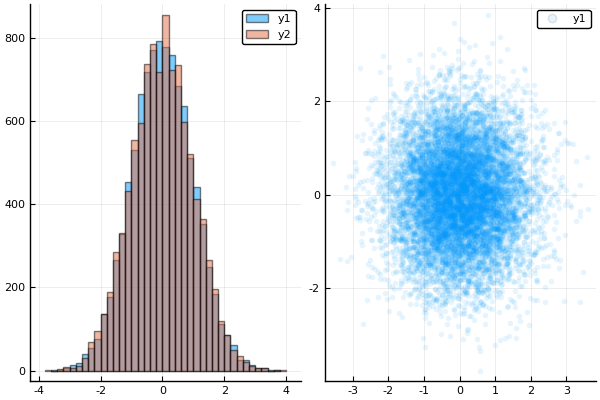

In [6]:
v = box_muller(10000)
h1 = histogram(v[1],alpha=0.5)
h2 = histogram!(v[end],alpha=0.5)
s  = plot(v[1],v[end],seriestype=:scatter,markerstrokewidth=0,alpha=0.1)
plot(h2,s,layout=2)

## 3. Genetic Linkage Model

Solução numérica

0.57	1.8594222944881917e18

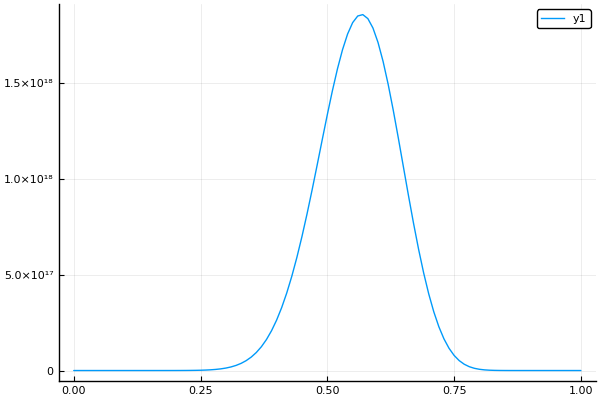

In [7]:
# using Distributions
post(θ,y) = ((2+θ)^y[1])*((1-θ)^(y[2]+y[3]))*θ^y[4]
v = [1,2,3,4]
post(0.1,v)

y = [69,9,11,11]
x = collect(0:0.01:1);
posterior = post.(x,Ref(y));
xmax = x[argmax(posterior)]
vmax = maximum(posterior)
print(xmax,"\t",vmax)
plot(x,posterior)

Solução simbólica

In [8]:
using SymPy
using LaTeXStrings

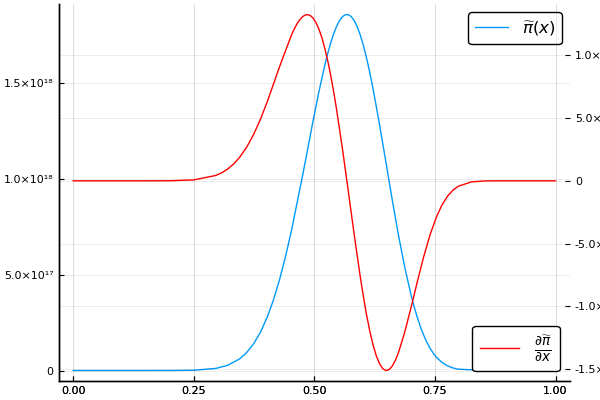

In [52]:
x  = symbols("x", real=true)
ex = ((2+x)^y[1])*((1-x)^(y[2]+y[3]))*x^y[4]
p1 = plot(ex, 0,1 ,label=L"\widetilde{\pi}(x)",legendfont=12)
p2 = plot!(twinx(),diff(ex), 0,1, label=L"\frac{\partial \widetilde{\pi}}{\partial x}",
    color="red",legend=:bottomright, legendfont=14)

In [55]:
solution = solve(diff(ex))
argmle = SymPy.N(solution[5])
mle    = round(SymPy.N(ex.subs(x,argmle)))

1.860237025726715232e+18

In [11]:
# Testando 10 de uma vez - somente um exemplo
x = rand(10)
u = rand(10)
aceitos = x[u .<= post.(x,Ref(y))]

9-element Array{Float64,1}:
 0.06937071764028446
 0.19057259247039893
 0.08701842209730115
 0.5751433664078265 
 0.12461457665387754
 0.3164759824043568 
 0.2423816948333697 
 0.42199344407785633
 0.17978484728644828

In [12]:
function rejection_sampling(N=1000)
    post(θ,y) = ((2+θ)^y[1])*((1-θ)^(y[2]+y[3]))*θ^y[4]
    y = [69,9,11,11]
    size = 0
    sample = zeros(N)
    T = zeros(0)
    t = 0
    while size < N
        x = rand()
        u = rand()
        if u <= post(x,y)/mle
            size+=1
            sample[size] = x
            append!(T , t)
            t = 0
        end
        t += 1
        
    end
    return sample, T
end

rejection_sampling (generic function with 2 methods)

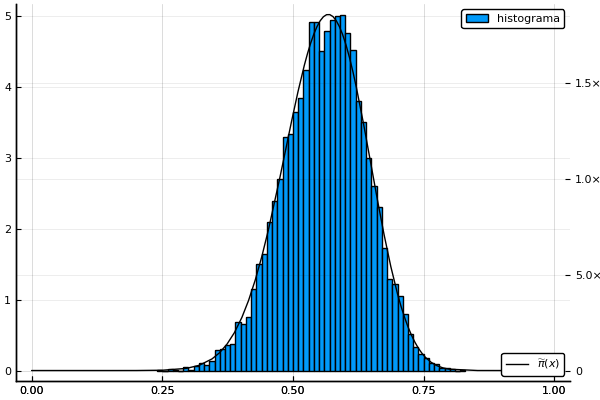

In [13]:
sample, T = rejection_sampling(10_000) 
histogram(sample,normalize=true, label="histograma")
plot!(twinx(),ex, 0,1 ,label=L"\widetilde{\pi}(x)",color="black",legend=:bottomright)

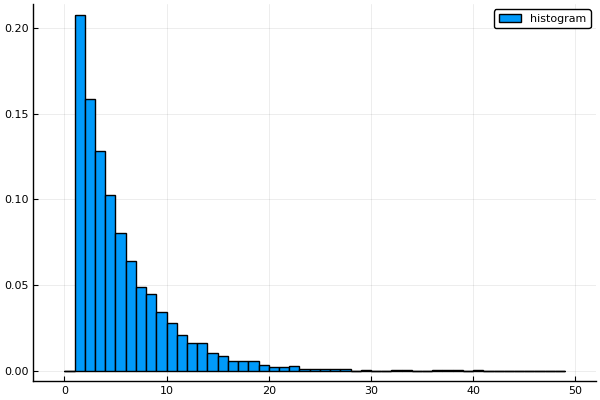

In [14]:
histogram(T,normalize=true, label="histogram",bins=0:maximum(T))

## 4. Mixture of Gaussians

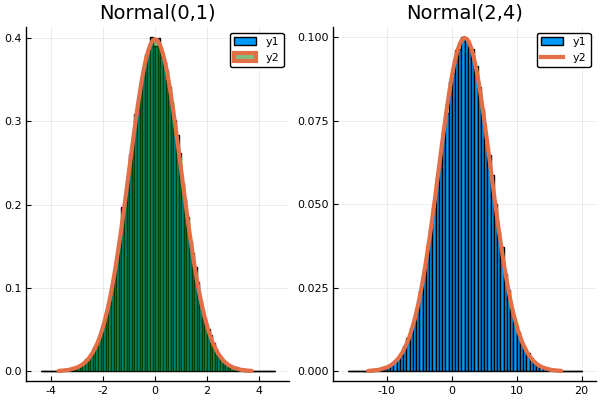

In [15]:
using Distributions
using StatsPlots
p1 = (histogram(box_muller(10_0000)[1],normalized=true, title="Normal(0,1)"); plot!(Normal(0,1),fill=(0,0.5,:green),linewidth = 3));
# histogram!(randn(10_0000),alpha=0.5,normalized=true)
μ = 2
σ = 4
p2 = (histogram(σ.*box_muller(100_000)[1].+μ,normalized=true,title="Normal(2,4)"); plot!(Normal(μ,σ),linewidth = 3));

plot(p1,p2)

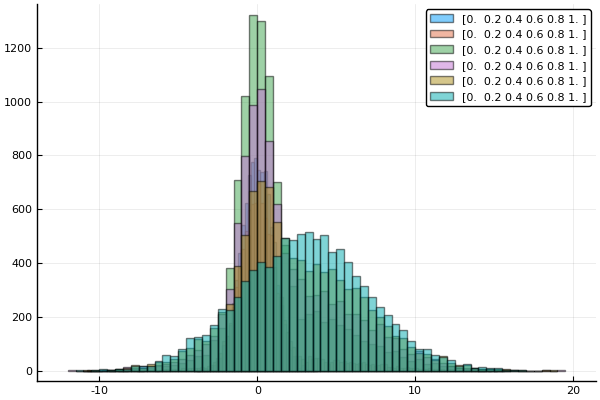

In [16]:
function mixture(N=1000,mix_rate=0.5,μ1=0,σ1=1,μ2=0,σ2=1)
    W   = rand(N) .<= (1-mix_rate)
    X,Y = box_muller(N)
    X   = σ1.*X .+ μ1
    Y   = σ2.*Y .+ μ2
    Mix = (X).*(W*1) + Y.*(.!W*1)
    return Mix
end

mix = collect(0:0.2:1)
histogram(mixture.(Ref(10_000),mix,Ref(0),Ref(1),Ref(3),Ref(4)),alpha=0.5,label=mix)

## 5. Monte Carlo

-cos(20)/20 + sin(50)/50 + 1/20 = 2.434839983525182497859873401536530122730170518476258840335731821647793935411972e-02


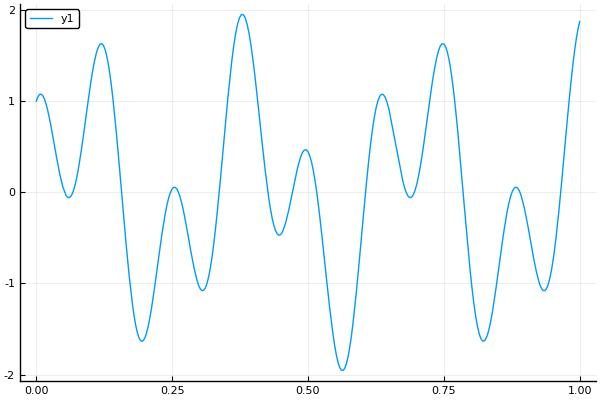

In [50]:
x  = symbols("x")
eq = cos(50*x)+sin(20*x)
I  = integrate(eq,(x,0,1)) # valor simbolico da integral 
Iv = SymPy.N(I)            # valor numerico da integral
println(I," = ",Iv)
plot(eq,0,1)

Como a equação adquire valores negativos, iremos somar 2 e depois subtrair.

In [18]:
function rejection_sampling(N=1000,M=4)
    f(x) = cos(50*x)+sin(20*x)+2
    size = 0
    sample = zeros(N)
    T = zeros(0)
    t = 0
    while size < N
        x = rand()
        u = rand()
        if u <= f(x)/M
            size+=1
            sample[size] = x
            append!(T , t)
            t = 0
        end
        t += 1
        
    end
    return sample, T
end

rejection_sampling (generic function with 3 methods)

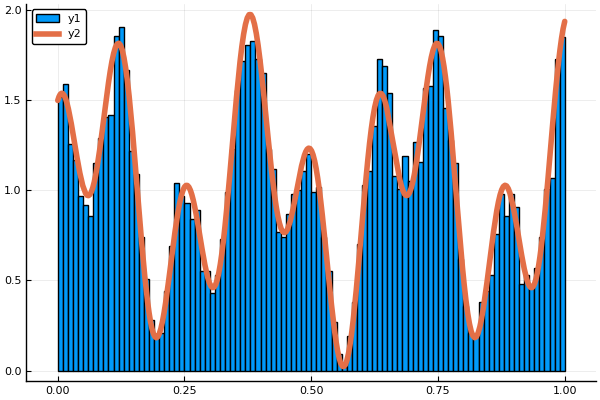

In [19]:
sample, T = rejection_sampling(10_000) 
histogram(sample,bins=0:0.01:1,normalized=true)
plot!((eq+2)/2,0,1,linewidth=4)

In [43]:
using StatsBase
using LinearAlgebra
h = fit(Histogram,sample,nbins=40)

Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  0.0:0.05:1.0
weights: [651, 563, 808, 281, 335, 376, 391, 865, 551, 516, 357, 138, 692, 587, 747, 637, 159, 411, 295, 640]
closed: left
isdensity: false

In [48]:
h.weights

20-element Array{Int64,1}:
 651
 563
 808
 281
 335
 376
 391
 865
 551
 516
 357
 138
 692
 587
 747
 637
 159
 411
 295
 640

In [20]:
f(x) = cos(50*x)+sin(20*x)
N    = 100_000
Ihat = sum(f.(rand(N)))/N

ϵ = abs(Ihat - Iv)/Ihat
println(ϵ)
println(Iv,"\t",Ihat)

7.937097428849559143674405594308499787325479208220470027241109938685306100120668e-02
2.434839983525182497859873401536530122730170518476258840335731821647793935411972e-02	0.022557953118298283


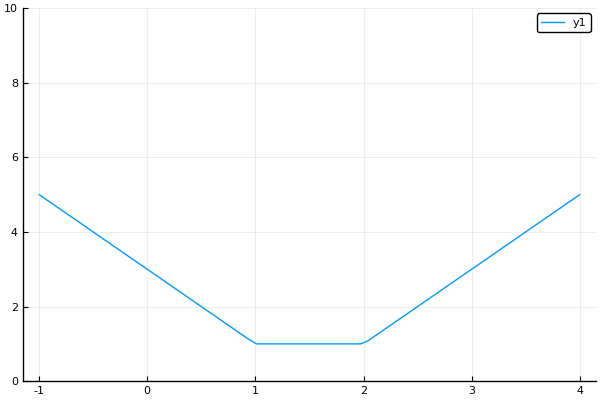

In [32]:
x = symbols("x")
fx= abs(x-1)+abs(x-2)
plot(fx,-1,4)
Plots.ylims!(0,10)

In [56]:
# 
